# Time Series Data
### Looking to the past to infer  the future

Time series data is a special kind of data that we will be exploring in this notebook. Time series data has a few important properties such as:
- it's sequential
- time is the independent variable
- observed at discrete intervals, such as 5 minutes or 1 hour

Let's dive into some examples of time series data and learn how we can observe, understand, and predict this unique kind of data.

In [1]:
# import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import autograd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import time
import datetime
import os
import sys

# matplotlib configuration
%matplotlib inline
plt.style.use('ggplot')

# What is Time Series Data
Time series data consists of data points recorded at discrete intervals over time. This kind of data occurs everywhere in our lives, a few examples include:
- Stock market data
- Ocean tides
- Commute times
- Weather and outdoor temperatures
- Business sales or revenue
- Disney World line wait times
and so many more examples. Time series data is so common, it becomes increasingly important to learn how to analyze it. In this notebook, we'll be taking on the challenge of using the past to predict the future.

# Dow Jones Industrial Average
Abbreviated as DJI and commonly refered to as the "Dow", this financial index monitors the prices of 30 large US companies such as Apple, Home Depot, IBM and Disney. The Dow is a good indicator of how the US stock markets are performing overall. The Dow dates back to 1885 and was founded by a Wall Street Journal reporter, Charles Dow, and his statitician, Edward Jones. We're going to take a look at the Dow and use it as an example to learn some important properties of time series data.

## Columns
- Date
    Our data dates back to 1985. It includes every day the stock market open, which is normal week days. This excludes weekends and holidays.
- Open
    The price our data opens 9:30 AM New York Time.
- High
    The highest price the Dow reaches during the day.
- Low
    The lowest price of the Dow during each day
- Close
    The price of the Dow when the market closes at 4:00 New York Time.
- Adj Close
    The closing price adjusted for dividends and stock splits.
- Volume
    The number of transactions on the market during each day.


In [2]:
# load data for Dow Jones Index
dateparse = lambda x: time.strptime(x, '%Y-%m-%d')
df = pd.read_csv('data/DJI.csv', delimiter=',', parse_dates=['Date'], date_parser=dateparse)
#dates = df['Date']
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"(1985, 1, 29, 0, 0, 0, 1, 29, -1)",1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,"(1985, 1, 30, 0, 0, 0, 2, 30, -1)",1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,"(1985, 1, 31, 0, 0, 0, 3, 31, -1)",1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,"(1985, 2, 1, 0, 0, 0, 4, 32, -1)",1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,"(1985, 2, 4, 0, 0, 0, 0, 35, -1)",1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


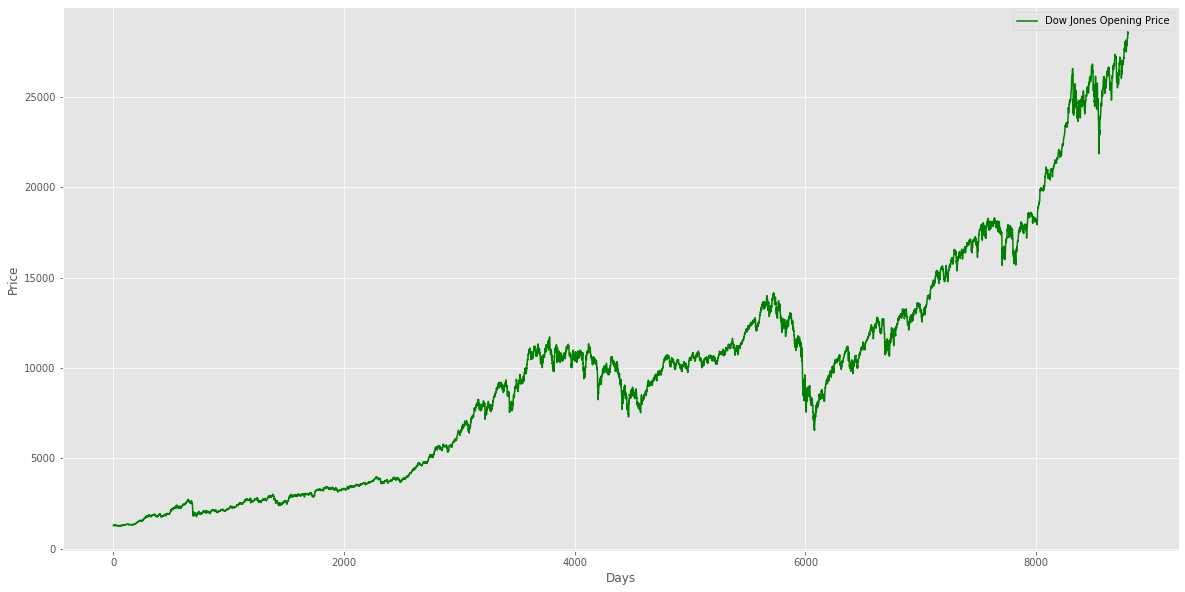

In [3]:
# plot raw data
# plotting with dates on the X axis is an absolute nightmare
    # Takes over a couple minutes for matplotlib to convert the values to their own datetime format
    # poor documentation and support
    # requires a ton of extra code that can clutter
    
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df['Open'], color='green', label='Dow Jones Opening Price')
ax.set_ylabel('Price')
ax.set_xlabel('Days')
ax.legend()
plt.show()


# Moving Averages
The first analysis tool that we'll be looking at is called a moving average. We're going to be looking at a subset of our data across a given range, and then be taking the average of all of the observations within that range. To do this, we'll loop through our entire dataset, then loop through each sliding window and calculate the average of that window.

In [4]:
# calculate 5 day moving average
MA5 = []

# start at the fifth index and loop through all data
for i in range(5, len(df)):
    # sum previous 5 data points and average them
    sum = 0
    for j in range(i-5, i):
        sum += df['Adj Close'][j]
    # add the average to the list
    MA5.append(sum / 5)
    

# drop rows 0 - 5
df = df[:-5]

# append the moving average to the data frame
df['MA5'] = MA5


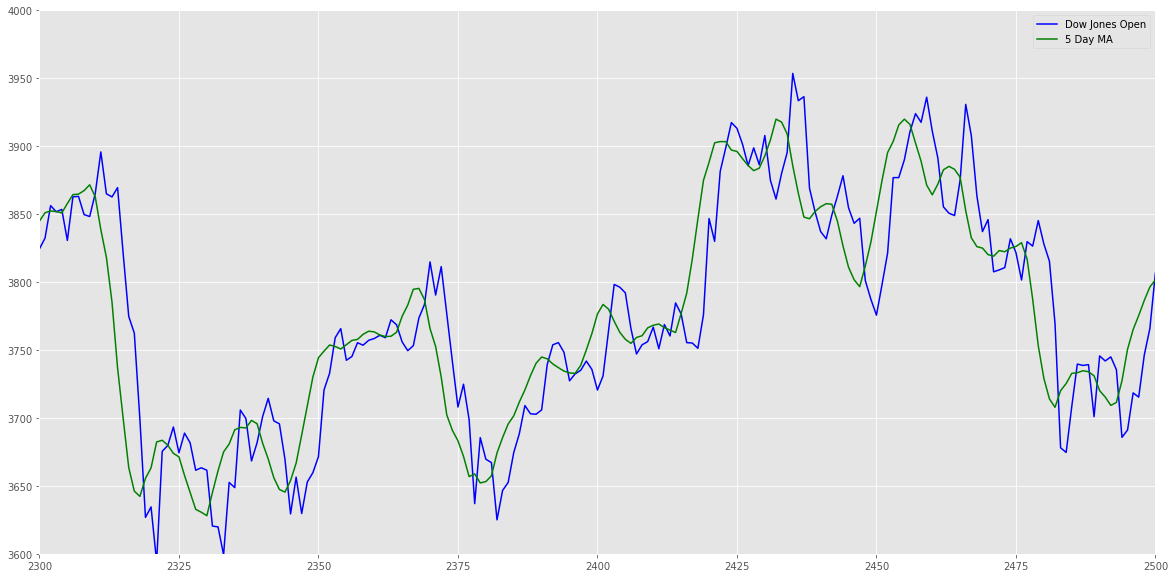

In [5]:
# Let's take a look at the 5 day moving average we just calculated

fig, ax = plt.subplots(figsize=(20,10))

# zoom in a bit
plt.axis([2300, 2500, 3600, 4000])
ax.plot(df['Open'], color='blue', label='Dow Jones Open')
ax.plot(df['MA5'], color="green", label='5 Day MA')
ax.legend()
plt.show()

In [6]:
# define a list of averages to calculate
averages = [10, 15, 50, 100, 200, 500]

# expand our data to several different moving averages
for avg in averages:
    # easier way to calculate moving averages than using for loop method
    df['MA' + str(avg)] = df['Adj Close'].rolling(window=avg).mean()

In [7]:
# view the new moving averages in our data frame
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA15,MA50,MA100,MA200,MA500
0,"(1985, 1, 29, 0, 0, 0, 1, 29, -1)",1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,1287.013989,NaN,NaN,NaN,NaN,NaN,NaN
1,"(1985, 1, 30, 0, 0, 0, 2, 30, -1)",1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1285.535986,NaN,NaN,NaN,NaN,NaN,NaN
2,"(1985, 1, 31, 0, 0, 0, 3, 31, -1)",1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,1284.077979,NaN,NaN,NaN,NaN,NaN,NaN
3,"(1985, 2, 1, 0, 0, 0, 4, 32, -1)",1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,1284.739966,NaN,NaN,NaN,NaN,NaN,NaN
4,"(1985, 2, 4, 0, 0, 0, 0, 35, -1)",1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,1287.189966,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# drop rows with null values, which is up to our largest moving average
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA15,MA50,MA100,MA200,MA500
499,"(1987, 1, 21, 0, 0, 0, 2, 21, -1)",2088.439941,2123.879883,2079.020020,2094.070068,2094.070068,24010000,2119.797998,2051.392993,2018.485986,1940.728201,1882.736097,1855.621652,1586.637402
500,"(1987, 1, 22, 0, 0, 0, 3, 22, -1)",2090.830078,2151.860107,2083.659912,2145.669922,2145.669922,22940000,2133.661963,2065.734985,2035.133984,1945.795798,1885.209397,1857.456901,1588.343501
501,"(1987, 1, 23, 0, 0, 0, 4, 23, -1)",2158.459961,2214.570068,2062.850098,2101.520020,2101.520020,40930000,2136.529981,2075.295984,2046.747982,1949.907200,1887.520997,1858.993001,1589.970781
502,"(1987, 1, 26, 0, 0, 0, 0, 26, -1)",2103.629883,2125.419922,2079.719971,2107.280029,2107.280029,18300000,2147.833984,2085.081982,2055.811987,1954.178801,1889.780498,1860.578501,1591.611802
503,"(1987, 1, 27, 0, 0, 0, 1, 27, -1)",2121.479980,2160.850098,2110.239990,2150.449951,2150.449951,21710000,2162.261963,2098.832983,2067.519987,1959.943801,1892.087898,1862.304200,1593.357261


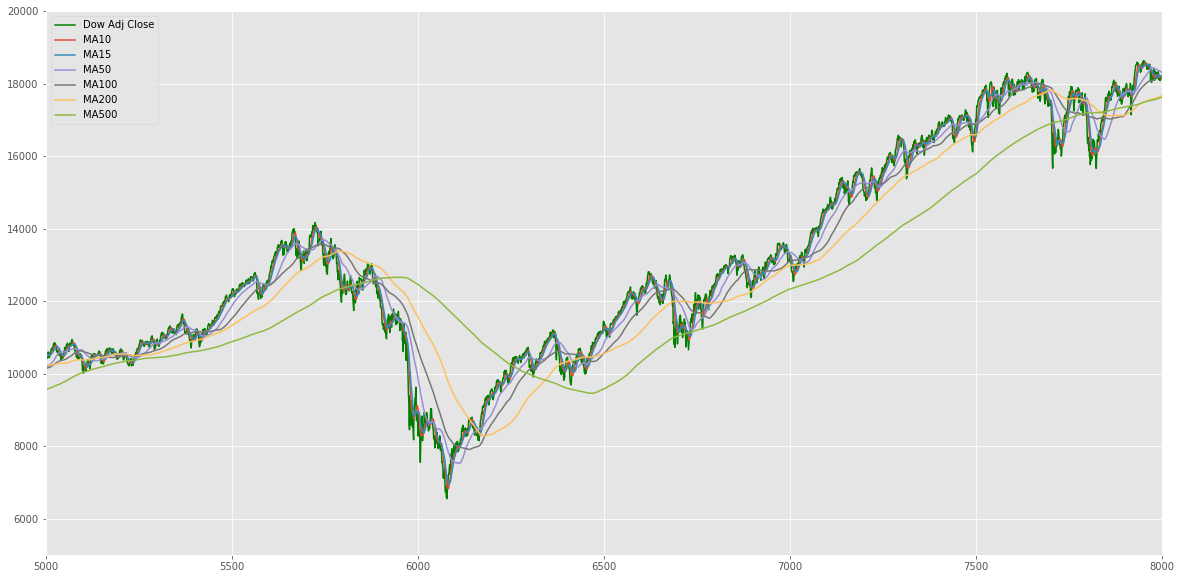

In [9]:
fig, ax = plt.subplots(figsize=(20,10))

# adjust the view
plt.axis([5000, 8000, 5000, 20000])

ax.plot(df['Adj Close'], c='green', label='Dow Adj Close')

for avg in averages:
    name = 'MA' + str(avg)
    ax.plot(df[name], label=name)

ax.legend()
plt.show()

# Exponential Moving Averages
Exponential moving averages work similarly to simple moving averages, except they add greater weight to more recent values. This is a good way to see what our trends look like with some "memory" of the past, while still being reactive to recent trends and sudden movements.

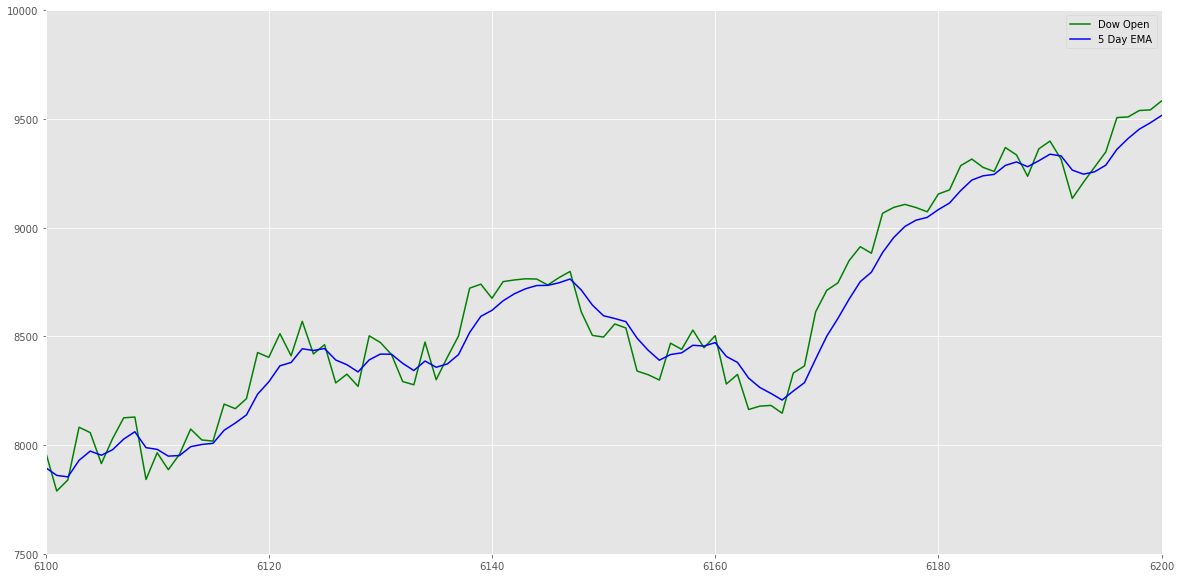

In [10]:
# EWM: Exponential Weighted Functions

df['EMA5'] = df['Open'].ewm(span=5, adjust=False).mean()

fig, ax = plt.subplots(figsize=(20,10))
plt.axis([6100, 6200, 7500, 10000])

ax.plot(df['Open'], c='green', label='Dow Open')
ax.plot(df['EMA5'], c='blue', label='5 Day EMA')
ax.legend()
plt.show()

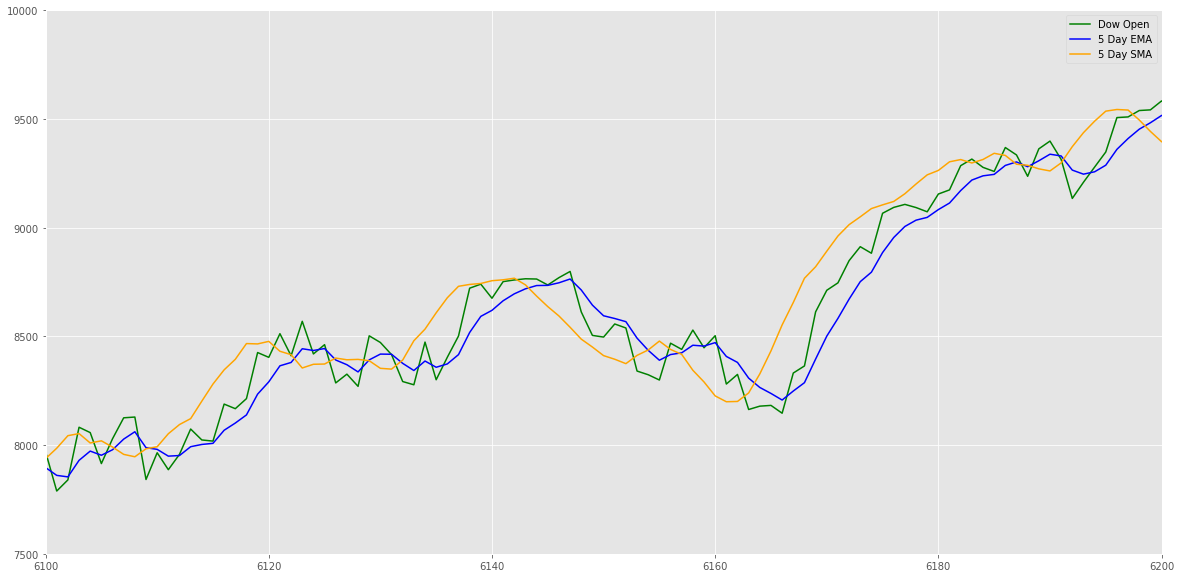

In [11]:
# compare EMA to SMA
fig, ax = plt.subplots(figsize=(20,10))
plt.axis([6100, 6200, 7500, 10000])
ax.plot(df['Open'], c='green', label='Dow Open')
ax.plot(df['EMA5'], c='blue', label='5 Day EMA')
ax.plot(df['MA5'], c='orange', label='5 Day SMA')
ax.legend()
plt.show()

# Decomposing Data
For any given time series data set, there are a lot of factors that go into each value. For the stock market, some of it is seemingly random, yet many top traders are able to extract useful information in order to better their odds. Decomposing data is the method of extracting each working piece of time series data.

## Seasonal Decomposition

### Additive formula: y(t) = S(t) + T(t) + R(t)
#### y = seaonality + trend + remainder

### Multiplicative formula: y(t) = S(t) * T(t) * R(t)
#### y = seaonality * trend * remainder

### Seasonality
Imagine data being subjected to cyclical forces, like tides of the ocean or seasons of the year

#### Examples
- In most locations, the temperature is going to cooler in winter in warmer in summer
- TSA wait times are going to be longer during holiday seasons.
- Historically stocks perform the worst in september.

### Trend
What sort of momentum does the data have?

#### Examples
- Moore's Law
- Increasing global population
- Global poverty decreasing

### Remainder
Randomness, noise

#### Examples
- microsecond flucuations in the price of the stock
- seemingly random warm day in winter

## Air Travel Passenger Dataset
This data set shows the number of monthly airline travelers from 1949 to 1960. Maybe you are one of the many people that have experienced the long wait times and crowded planes during the holidays. The data shows this huge uptick that occurs during each year, seemingly like clockwork. We're going to be applying seasonal decomposition to this dataset and learn how we can find each of the working pieces of this time series data.

In [12]:
df = pd.read_csv('data/AirPassengers.csv', delimiter=',')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


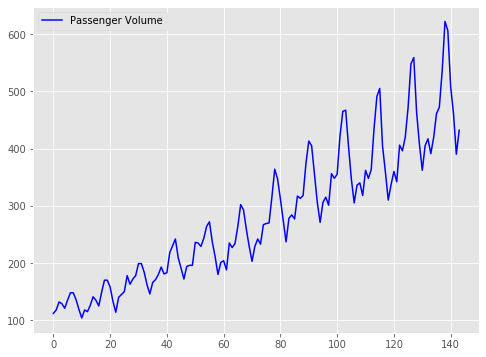

In [13]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(df['Passengers'], color='blue', label='Passenger Volume')
ax.legend()
plt.show()

## Detrending Data
Many factors influence the measurements we observe in time series data. For instance, in the 20th century, air travel was an emergent industry that saw a steady increase. We can estimate this general trend of growth and then subtract it from each point to greater understand the other trends that have influence. Once we detrend our data, we can isolate and observe the seasonality in our data.

### Setting a Base Line
This step is going to be highly dependent on the data set being detrended. In most cases that show a generally increasing or decreasing trend, there will be a sort of "Goldilocks" value that will work well. Try to establish some sort of baseline that is around the low end of the data and covers most of the are underneath the data. In this example, we'll be using a 50 month moving average that creates a nice baseline to our data




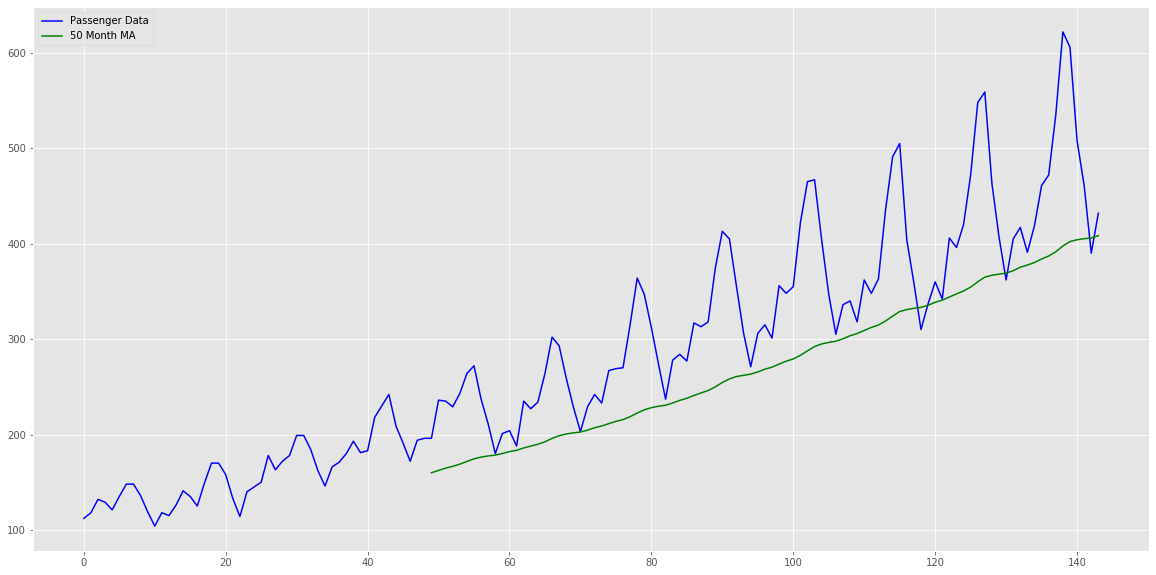

In [14]:
# Use the 50 Month moving average as the trend line 
df['MA50'] = df['Passengers'].rolling(window=50).mean()

# plot the the trend line
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df['Passengers'], color='blue', label='Passenger Data')
ax.plot(df['MA50'], color='green', label='50 Month MA')
ax.legend()
plt.show()

## Let's use some algebra
### S(t) + R(t) = y(t) - T(t)
By subtracting our trend line from our seasonal data, we'll be left with our seasonal data, plus some randomness.

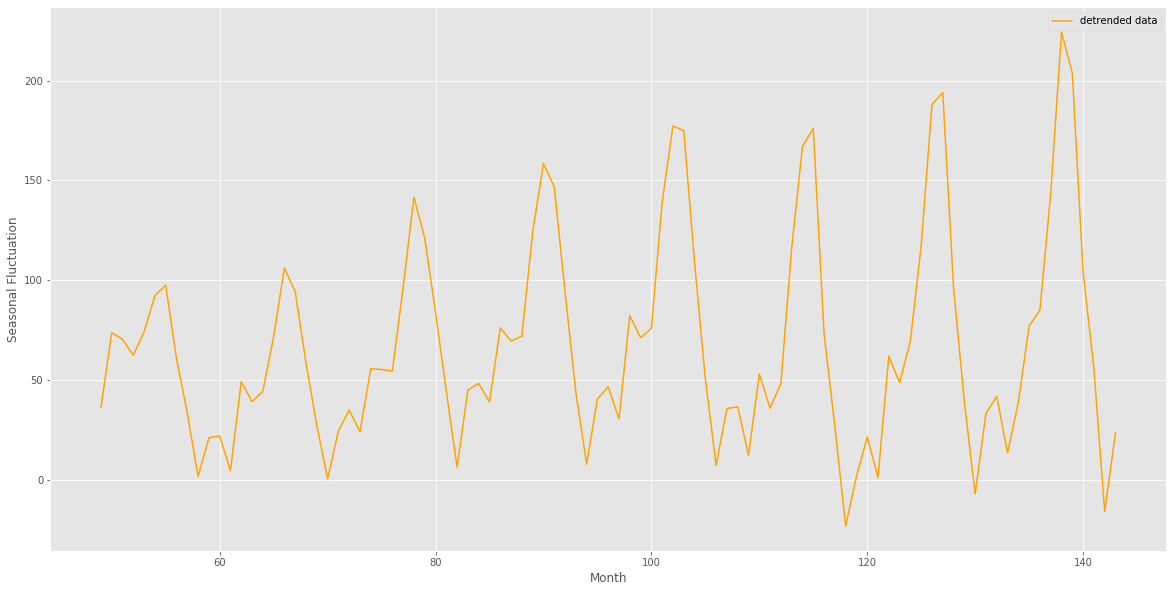

In [15]:
# subtract the trend line from the passenger data
df['detrend'] = df['Passengers'] - df['MA50']

# plot detrended data
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df['detrend'], color='orange', label='detrended data')
ax.set_xlabel('Month')
ax.set_ylabel('Seasonal Fluctuation')
ax.legend()
plt.show()

### Find Seasonality
In the graph above, it's obvious that our data follows a cyclical pattern. In this next bit of code, what we're going to do is overlay each year on top of each other to show the recurrent pattern.

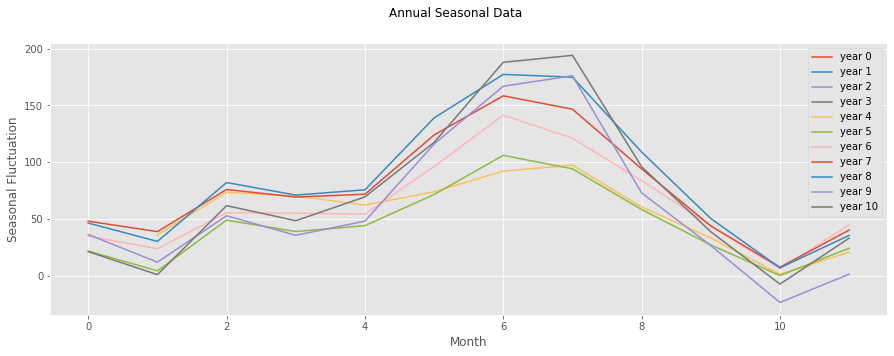

In [16]:
# create a new dataframe to hold our annual detrended data
annual = pd.DataFrame()

# iterate and chop our data into 12 month periods
i = 0
while (i * 12) < (len(df['detrend']) - 12):
    x = i * 12
    annual[i] = df['detrend'].iloc[x:x+12].reset_index(drop=True)
    i += 1

fig, ax = plt.subplots(figsize=(15,5))
fig.suptitle('Annual Seasonal Data')
for i in range(0, 11):
    ax.plot(annual[i], label='year '+str(i))

ax.set_xlabel('Month')
ax.set_ylabel('Seasonal Fluctuation')
ax.legend()
plt.show()

## Seasonal Mean
To identify what our seasonal fluctuation looks like on average, we'll be taking the average of each year. Doing this will allow us to estimate what our seasonal difference may look like in the future.

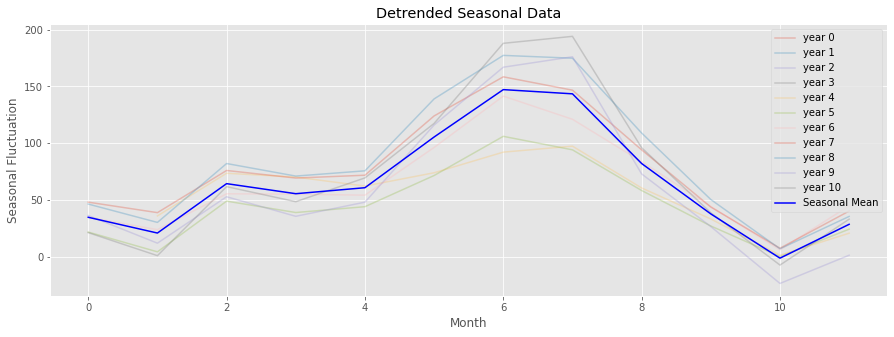

In [17]:
# Find the average seasonal data by taking the mean from each year
annual['Seasonal Mean'] = annual.mean(axis=1)
# blue line represents seasonal trend
fig, ax = plt.subplots(figsize=(15,5))
for i in range(0, 11):
    ax.plot(annual[i], label='year '+ str(i), alpha=0.3)

# TODO: Add transparency to each year so mean stands out more
ax.set_title('Detrended Seasonal Data')
ax.plot(annual['Seasonal Mean'], color='blue', label='Seasonal Mean')
ax.legend()
ax.set_ylabel('Seasonal Fluctuation')
ax.set_xlabel('Month')
plt.show()

## Multiplicative Formula
In the cell below, we're going to implement a multiplicative formula using the statsmodels seasonal decomposition library. This library will expidite a lot of the previous work we just did.

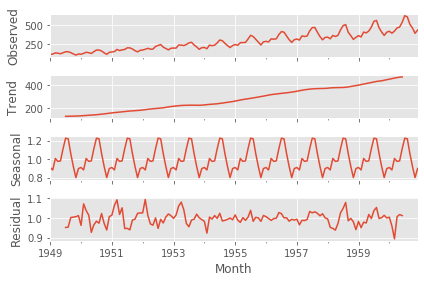

In [18]:
# implemented with statsmodels
# not as much fun, but a whole lot easier
from statsmodels.tsa.seasonal import seasonal_decompose

# strips time
def parser(x):
    return pd.datetime.strptime(x, '%Y-%m')

data = pd.read_csv('data/AirPassengers.csv', delimiter=',', index_col=['Month'], parse_dates=True, squeeze=True, date_parser=parser)

# try toggling the model between additive and multiplicative!
res = seasonal_decompose(data, model='multiplicative')
res.plot()
plt.show()

# ARIMA
ARIMA stands for Autoregressive Integrated Moving Average

### AR: Autoregression
Model that uses the dependent relationship between an observation and some number of lagged observations.

### I: Integrated
Integrated meaning the decomposition of data using differencing, or subtracting previous values from each other, to make the data stationary.

### MA: Moving Average
Average of previous time series observations over a given period.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

#### p: The number of lag observations included in the model, also called the lag order.
#### d: The number of times that the raw observations are differenced, also called the degree of differencing.
#### q: The size of the moving average window, also called the order of moving average.

source, and for more information on ARIMA: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

## Autocorrelation
Autocorrelation is the similarity between observed time series observations. By analyzing autocorrelation, we can try to pick up signals such as seasonality and fluctuation.
By plotting autocorrelation, we can see which time lag window has the highest correlation. When we make the ARIMA model, we want to pick a lag observation window that has a high correlation. We can adjust this window using our "p" parameter

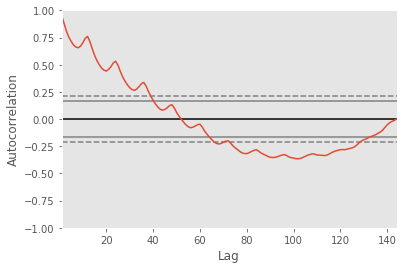

In [19]:
from pandas.plotting import autocorrelation_plot


# load Air Travel data
data = pd.read_csv('data/AirPassengers.csv', delimiter=',', index_col=['Month'], parse_dates=True, squeeze=True, date_parser=parser)
# plot autocorrelation
autocorrelation_plot(data)
plt.show()

## ARIMA With Regression
Let's take a look at an ARIMA model that uses regression on the lag to fit to our trainig
https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

In [20]:
# date time parser
def parser(x):
    return pd.datetime.strptime(x, '%Y-%m')
 
# Let's start over with a fresh data frame
df = pd.read_csv('data/AirPassengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# Isolate values
X = df.values

# manual test-train split
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

# create a new list for our training data. We'll expand this list once we "see" testing values
history = [x for x in train]

# list to store just our predictions
predictions = []

predicted=279.908331, expected=306.000000
predicted=346.953500, expected=315.000000
predicted=325.749787, expected=301.000000
predicted=305.826160, expected=356.000000
predicted=365.160635, expected=348.000000
predicted=330.488091, expected=355.000000
predicted=368.172556, expected=422.000000
predicted=417.317435, expected=465.000000
predicted=468.888432, expected=467.000000
predicted=462.688151, expected=404.000000
predicted=368.300061, expected=347.000000
predicted=340.324495, expected=305.000000
predicted=308.878355, expected=336.000000
predicted=383.349024, expected=340.000000
predicted=351.781300, expected=318.000000
predicted=322.739366, expected=362.000000
predicted=372.884392, expected=348.000000
predicted=333.332444, expected=363.000000
predicted=382.493417, expected=435.000000
predicted=435.787752, expected=491.000000
predicted=502.006327, expected=505.000000
predicted=497.701934, expected=404.000000
predicted=347.130149, expected=359.000000
predicted=364.777287, expected=310

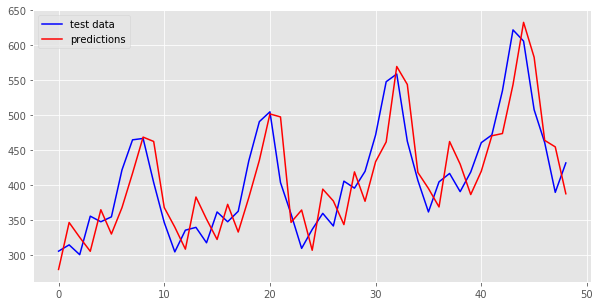

In [21]:
# Make predictions at each point in our testing data
for t in range(len(test)):
    # since our training data is dynamically growing, we make and train a new model each iteration
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    
    # make a prediction
    output = model_fit.forecast()
    
    # forecast method returns a tuple, take the first value
    yhat = output[0]
    
    # add prediction to our list
    predictions.append(yhat)
    
    # add our testing value back into our history
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test, color='blue', label='test data')
ax.plot(predictions, color='red', label='predictions')
ax.legend()
plt.show()

# Corona Virus Dataset


In [54]:
df = pd.read_csv('data/COV_19/covid_19_data.csv', delimiter=',')
print(df.head())


   SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0  


In [55]:

#print(df.set_index('SNo'))


In [56]:
# TODO: sum up confirmed cases and plot a graph

# this may help! https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html
# and this https://stackoverflow.com/questions/8703496/hash-map-in-python
keys = [date for date in df['ObservationDate'].unique()]
timeCases = dict.fromkeys(keys)
df = df.set_index('ObservationDate')

### BEGIN SOLUTION


### END SOLUTION

# try creating a new column that contains the total number of confirmed cases at each time


SNo
Province/State
Country/Region
Last Update
Confirmed
Deaths
Recovered
